### Question 2: spam detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA

In [2]:
#Load the dataset
data = pd.read_csv('sms+spam+collection/SMSSpamCollection',sep='\t', names=['label', 'message'])

# Convert to lower case and remove any punctution the message column
data['message'] = data['message'].str.lower().apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

# Tokenize the message
data['message'] = data['message'].apply(word_tokenize)

# Define X and y
X = data['message']
y = data['label'].apply(lambda x: 1 if x =='spam' else 0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


In [3]:
# Separate spam and ham messages
spam_messages = X_train[y_train == 1]
ham_messages = X_train[y_train == 0]

# Count word occurrences in each class
spam_words = Counter([word for message in spam_messages for word in message])
ham_words = Counter([word for message in ham_messages for word in message])

# Calculate class probabilities
p_spam = len(spam_messages) / len(X_train)
p_ham = len(ham_messages) / len(X_train)

# Vocabulary size
vocab = set(word for message in X_train for word in message)
vocab_size = len(vocab)

# Function to calculate word probabilities for each class
def word_probabilities(word_counts, total_words, vocab_size):
    return {word: (count / total_words) for word, count in word_counts.items()}

# Calculate word probabilities for spam and ham
spam_probabilities = word_probabilities(spam_words, sum(spam_words.values()), vocab_size)
ham_probabilities = word_probabilities(ham_words, sum(ham_words.values()), vocab_size)


In [4]:
# Prediction function using MLE
def predict_mle(message):
    p_spam_message = np.log(p_spam)
    p_ham_message = np.log(p_ham)
    
    for word in message:
        if word in spam_probabilities:
            p_spam_message += np.log(spam_probabilities[word])
        if word in ham_probabilities:
            p_ham_message += np.log(ham_probabilities[word])

    return 1 if p_spam_message > p_ham_message else 0


In [5]:
# Apply prediction function to test set
y_pred_mle = [predict_mle(message) for message in X_test]

# Evaluate MLE classifier
accuracy_mle = accuracy_score(y_test, y_pred_mle)
precision_mle = precision_score(y_test, y_pred_mle)
recall_mle = recall_score(y_test, y_pred_mle)
f1_mle = f1_score(y_test, y_pred_mle)

# pring the evaluation

print(f"Accuracy: {accuracy_mle:.2f}")
print(f"Precision: {precision_mle:.2f}")
print(f"Recall: {recall_mle:.2f}")
print(f"F1 Score: {f1_mle:.2f}")

Accuracy: 0.17
Precision: 0.04
Recall: 0.26
F1 Score: 0.08


### Step 3

In [6]:
# Function with Laplace smoothing
def word_probabilities_laplace(word_counts, total_words, vocab_size, alpha=1):
    return {word: (count + alpha) / (total_words + alpha * vocab_size) for word, count in word_counts.items()}


In [7]:
# Prediction function for MAP with Laplace smoothing
def predict_map(message, alpha=1):
    p_spam_message = np.log(p_spam)
    p_ham_message = np.log(p_ham)
    
    for word in message:
        p_spam_message += np.log(spam_probabilities.get(word, alpha / (sum(spam_words.values()) + alpha * vocab_size)))
        p_ham_message += np.log(ham_probabilities.get(word, alpha / (sum(ham_words.values()) + alpha * vocab_size)))
    
    return 1 if p_spam_message > p_ham_message else 0


In [8]:
# Evaluate MAP classifier
y_pred_map = [predict_map(message) for message in X_test]

accuracy_map = accuracy_score(y_test, y_pred_map)
precision_map = precision_score(y_test, y_pred_map)
recall_map = recall_score(y_test, y_pred_map)
f1_map = f1_score(y_test, y_pred_map)


# print evaluation

print(f"Accuracy: {accuracy_map:.2f}")
print(f"Precision: {precision_map:.2f}")
print(f"Recall: {recall_map:.2f}")
print(f"F1 Score: {f1_map:.2f}")

Accuracy: 0.97
Precision: 0.84
Recall: 0.97
F1 Score: 0.90


In [9]:
# Comparison Table
comparison = pd.DataFrame({
    'Model': ['MLE', 'MAP'],
    'Accuracy': [accuracy_mle, accuracy_map],
    'Precision': [precision_mle, precision_map],
    'Recall': [recall_mle, recall_map],
    'F1 Score': [f1_mle, f1_map]
})
print(comparison)


  Model  Accuracy  Precision    Recall  F1 Score
0   MLE  0.173991   0.044811  0.255034  0.076229
1   MAP  0.972197   0.843023  0.973154  0.903427


- Incorporating prior knowledge in the Maximum A Posteriori (MAP) estimation significantly improved model performance compared to Maximum Likelihood Estimation (MLE). 

#### 1. Impact of Prior Knowledge in MAP on Predictions
**Accuracy:** MAP’s accuracy of 0.9695 far exceeds MLE’s 0.1919. By incorporating prior knowledge, MAP makes more informed predictions, leading to a substantial boost in overall accuracy. This prior knowledge helps MAP by adjusting probabilities to better fit the data's characteristics, unlike MLE, which relies on observed data frequencies without adjustments for prior probabilities.
**Precision, Recall, and F1 Score:** MAP also performs far better, Precision increases from 0.0381 (MLE) to 0.8402 (MAP), and Recall rises from 0.2081 (MLE) to 0.9530 (MAP). This shows that MAP is both more selective and accurate in identifying relevant messages, minimizing false positives and capturing true positives effectively. The F1 Score—a harmonic mean of Precision and Recall—also reflects MAP’s balanced performance, moving from 0.0644 to 0.8931.
#### 2. Changes in Classification Between MLE and MAP
With MLE, the model likely misclassified a majority of messages, indicated by its low Precision and Recall. In contrast, MAP’s high Precision and Recall show a significant shift in classification accuracy and reliability, indicating that many messages were correctly reclassified.
The difference in classification implies that MLE could have been overly sensitive to noise or outliers in the data, leading to frequent misclassifications. MAP's incorporation of prior knowledge likely smoothed out these inconsistencies, resulting in a more accurate and consistent classification.
#### 3. Factors Contributing to Performance Differences
**Prior Knowledge Effect:** MAP’s prior knowledge enables it to anticipate likely patterns or distributions within the data, leading to more informed decisions even when data is sparse or noisy.
**Sensitivity to Rare Events:** MLE is heavily influenced by observed data frequencies, which can lead to poor performance if certain classes (like spam or ham) are underrepresented. MAP's prior knowledge can compensate for this by giving such classes a baseline probability, leading to better handling of rare events.
**Overfitting vs. Generalization:** Without prior knowledge, MLE can overfit to specific patterns in the training data, potentially reducing its generalizability. MAP’s regularization through prior knowledge helps avoid this overfitting, resulting in a model that generalizes better to new data.

#### Vary the Prior (MAP) - Step 5

In [10]:
# Testing MAP with different alpha values
alphas = [0.1, 0.5, 1, 5]
for alpha in alphas:
    y_pred_map_alpha = [predict_map(message, alpha=alpha) for message in X_test]
    accuracy = accuracy_score(y_test, y_pred_map_alpha)
    precision = precision_score(y_test, y_pred_map_alpha)
    recall = recall_score(y_test, y_pred_map_alpha)
    f1 = f1_score(y_test, y_pred_map_alpha)
    print(f"Alpha={alpha}: Accuracy={accuracy}, Precision={precision}, Recall={recall}, F1 Score={f1}")


Alpha=0.1: Accuracy=0.9838565022421525, Precision=0.9171974522292994, Recall=0.9664429530201343, F1 Score=0.9411764705882353
Alpha=0.5: Accuracy=0.9757847533632287, Precision=0.8630952380952381, Recall=0.9731543624161074, F1 Score=0.9148264984227129
Alpha=1: Accuracy=0.9721973094170404, Precision=0.8430232558139535, Recall=0.9731543624161074, F1 Score=0.9034267912772586
Alpha=5: Accuracy=0.9596412556053812, Precision=0.7857142857142857, Recall=0.959731543624161, F1 Score=0.8640483383685801


#### Discussion of Findings
The observations suggest that varying the 
𝛼
 value in Laplace smoothing has a distinct impact on model performance:

**Lower Alpha Values (0.1, 0.5):** Lower 
𝛼
 values provide higher accuracy and better balance between precision and recall. Minimal smoothing allows the MAP classifier to leverage prior knowledge without significantly compromising the model’s ability to distinguish between spam and ham accurately.

 
**Higher Alpha Values (1, 5):** As 
𝛼
 increases, the model’s predictions become more generalized, as it heavily incorporates prior probabilities. This increases the classifier's recall but reduces precision and overall accuracy, indicating that the model struggles to capture specific patterns within the data.

### Question 4: Mixture Models and the EM Algorithm

In [11]:
# Parameters for the true distribution
mu1, sigma1, pi1 = 0, 1, 0.3
mu2, sigma2, pi2 = 5, np.sqrt(2), 0.7
n_samples = 1000

# Generate synthetic data
np.random.seed(0)
data = np.hstack([
    np.random.normal(mu1, sigma1, int(n_samples * pi1)),
    np.random.normal(mu2, sigma2, int(n_samples * pi2))
])

# Initial parameters for EM
mu1_est, mu2_est = np.random.choice(data, 2)
sigma1_est, sigma2_est = 1, 1
pi1_est, pi2_est = 0.5, 0.5

# EM algorithm
def em_algorithm(data, mu1, mu2, sigma1, sigma2, pi1, pi2, max_iter=100, tol=1e-6):
    for i in range(max_iter):
        # E-step: Compute responsibilities (posterior probabilities for each component)
        r1 = pi1 * norm.pdf(data, mu1, sigma1)
        r2 = pi2 * norm.pdf(data, mu2, sigma2)
        gamma1 = r1 / (r1 + r2)
        gamma2 = r2 / (r1 + r2)
        
        # M-step: Update the parameters based on the current responsibilities
        mu1_new = np.sum(gamma1 * data) / np.sum(gamma1)
        mu2_new = np.sum(gamma2 * data) / np.sum(gamma2)
        sigma1_new = np.sqrt(np.sum(gamma1 * (data - mu1_new)**2) / np.sum(gamma1))
        sigma2_new = np.sqrt(np.sum(gamma2 * (data - mu2_new)**2) / np.sum(gamma2))
        pi1_new = np.mean(gamma1)
        pi2_new = np.mean(gamma2)
        
        # Check for convergence
        if (
            abs(mu1 - mu1_new) < tol and abs(mu2 - mu2_new) < tol and
            abs(sigma1 - sigma1_new) < tol and abs(sigma2 - sigma2_new) < tol and
            abs(pi1 - pi1_new) < tol and abs(pi2 - pi2_new) < tol
        ):
            print("Converged at iteration", i)
            break
        
        # Update parameters for the next iteration
        mu1, mu2 = mu1_new, mu2_new
        sigma1, sigma2 = sigma1_new, sigma2_new
        pi1, pi2 = pi1_new, pi2_new

    return mu1, mu2, sigma1, sigma2, pi1, pi2

# Run EM algorithm
mu1_est, mu2_est, sigma1_est, sigma2_est, pi1_est, pi2_est = em_algorithm(
    data, mu1_est, mu2_est, sigma1_est, sigma2_est, pi1_est, pi2_est
)

# Swap components if necessary
if mu1_est > mu2_est:
    mu1_est, mu2_est = mu2_est, mu1_est
    sigma1_est, sigma2_est = sigma2_est, sigma1_est
    pi1_est, pi2_est = pi2_est, pi1_est

print("Estimated parameters:")
print(f"mu1 = {mu1_est:.2f}, mu2 = {mu2_est:.2f}")
print(f"sigma1^2 = {sigma1_est**2:.2f}, sigma2^2 = {sigma2_est**2:.2f}")
print(f"pi1 = {pi1_est:.2f}, pi2 = {pi2_est:.2f}")


Converged at iteration 35
Estimated parameters:
mu1 = 0.02, mu2 = 4.89
sigma1^2 = 0.99, sigma2^2 = 1.92
pi1 = 0.30, pi2 = 0.70


In [12]:
# Code to help in doing the calculation

# Parameters for components
pi1, mu1, sigma1_squared = 0.5, 2, 1
pi2, mu2, sigma2_squared = 0.5, 7, 1

def gaussian_pdf(x, mu, sigma_squared):
    """Calculate the Gaussian PDF."""
    return (1 / np.sqrt(2 * np.pi * sigma_squared)) * np.exp(-((x - mu) ** 2) / (2 * sigma_squared))

def calculate_responsibilities(x, pi1, mu1, sigma1_squared, pi2, mu2, sigma2_squared):
    """Calculate responsibilities γ_i1 and γ_i2 for a data point x."""
    p_x_given_c1 = gaussian_pdf(x, mu1, sigma1_squared)
    p_x_given_c2 = gaussian_pdf(x, mu2, sigma2_squared)
    
    total = pi1 * p_x_given_c1 + pi2 * p_x_given_c2
    return (pi1 * p_x_given_c1 / total, pi2 * p_x_given_c2 / total)

# Always change the value of X usage
x = 8
gamma_i1, gamma_i2 = calculate_responsibilities(x, pi1, mu1, sigma1_squared, pi2, mu2, sigma2_squared)

# Output
print(f"PDF for component 1 at x = {x}: {gaussian_pdf(x, mu1, sigma1_squared)}")
print(f"PDF for component 2 at x = {x}: {gaussian_pdf(x, mu2, sigma2_squared)}")
print(f"Responsibility γ_i1: {gamma_i1}")
print(f"Responsibility γ_i2: {gamma_i2}")


PDF for component 1 at x = 8: 6.075882849823286e-09
PDF for component 2 at x = 8: 0.24197072451914337
Responsibility γ_i1: 2.510999092692816e-08
Responsibility γ_i2: 0.999999974890009


#### Quetion 4 - Iris dataset

In [13]:
# Load the Iris dataset
iris_df = sns.load_dataset("iris")

# Display the first few rows
print(iris_df.head())

# Standardize features
X = iris_df.drop('species', axis=1)

scaler = StandardScaler()
iris_scaler = scaler.fit_transform(X)

iris_scaler[:5]


   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

In [14]:
# Define the clusters
k = 3 #Because of the three species

# Define the number of features
n_features = iris_scaler.shape[1]

# Caculate the mean randomly
means = np.random.rand(k, n_features)

# Initialize the variance for each Gaussian
covariances = np.array([np.eye(n_features) for _ in range(k)])

# Mixing coefficients
mixing_coefficients = np.random.dirichlet(np.ones(k), size=1)[0]

# Display initial parameters
print("Initial Means:\n", means)
print("Initial Covariances:\n", covariances)
print("Initial Mixing Coefficients:\n", mixing_coefficients)



Initial Means:
 [[0.70052862 0.8830776  0.96657511 0.77474761]
 [0.99423308 0.61476989 0.0371296  0.01425152]
 [0.34210388 0.82347172 0.86613471 0.96081253]]
Initial Covariances:
 [[[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]

 [[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]

 [[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]]
Initial Mixing Coefficients:
 [0.02632426 0.01782413 0.95585161]


In [15]:
# Number of iterations for EM
n_iterations = 100
n_samples = iris_scaler.shape[0]
epsilon = 1e-6  # Small value to ensure covariance matrices are positive definite and avoid singular matrix error.

# Initialize responsibilities matrix (probabilities of each point belonging to each Gaussian)
responsibilities = np.zeros((n_samples, k))

# Initialize log-likelihood list to track convergence
log_likelihoods = []

# Perform EM Algorithm
for iteration in range(n_iterations):
    # E-step: Calculate the responsibilities (probabilities) for each data point
    for j in range(k):
        rv = multivariate_normal(mean=means[j], cov=covariances[j] + epsilon * np.eye(iris_scaler.shape[1]))  # Regularized covariance
        responsibilities[:, j] = mixing_coefficients[j] * rv.pdf(iris_scaler)  # Weighted PDF

    # Normalize responsibilities so that each data point's responsibilities sum to 1
    responsibilities = responsibilities / responsibilities.sum(axis=1, keepdims=True)
    
    # M-step: Update the parameters (means, covariances, mixing coefficients)
    
    # Calculate N_k (sum of responsibilities for each cluster)
    N_k = responsibilities.sum(axis=0)
    
    # Update the means (weighted average of the data points)
    means = (responsibilities.T @ iris_scaler) / N_k[:, np.newaxis]
    
    # Update covariances (weighted covariance matrix)
    covariances = []
    for j in range(k):
        diff = iris_scaler - means[j]  # Calculate the difference from the mean
        cov = (responsibilities[:, j][:, np.newaxis] * diff).T @ diff / N_k[j]  # Weighted covariance
        covariances.append(cov)
    covariances = np.array(covariances)
    
    # Update the mixing coefficients (weighted average of the responsibilities)
    mixing_coefficients = N_k / n_samples
    
    # Calculate the log-likelihood for this iteration
    log_likelihood = 0
    for j in range(k):
        rv = multivariate_normal(mean=means[j], cov=covariances[j] + epsilon * np.eye(iris_scaler.shape[1]))  # Regularized covariance
        log_likelihood += np.sum(np.log(responsibilities[:, j]) + np.log(mixing_coefficients[j]))  # Log of responsibilities
    
    # Track log-likelihoods to check for convergence
    log_likelihoods.append(log_likelihood)

    # Check for convergence (if the change in log-likelihood is very small)
    if iteration > 0 and abs(log_likelihood - log_likelihoods[-2]) < 1e-6:
        print(f"Converged after {iteration} iterations")
        break


Converged after 61 iterations


In [16]:
# Final means (centroids of the clusters)
print("Final Means (Centroids):")
print(means)

# Final covariances (variances and covariances)
print("\nFinal Covariances:")
for i in range(k):
    print(f"Cluster {i+1} Covariance Matrix:")
    print(covariances[i])

# Final mixing coefficients (weights of each Gaussian component)
print("\nFinal Mixing Coefficients:")
print(mixing_coefficients)


Final Means (Centroids):
[[ 2.03705632  0.10010898  1.49745691  1.01231172]
 [-1.01457879  0.85326345 -1.3049873  -1.25489351]
 [ 0.35767991 -0.47814608  0.56985701  0.58980715]]

Final Covariances:
Cluster 1 Covariance Matrix:
[[ 0.08402237  0.09997485  0.04508725  0.06123984]
 [ 0.09997485  0.87790399 -0.00330909  0.02346684]
 [ 0.04508725 -0.00330909  0.03894268  0.04948242]
 [ 0.06123984  0.02346684  0.04948242  0.07311359]]
Cluster 2 Covariance Matrix:
[[0.17876962 0.2712035  0.01103826 0.01614738]
 [0.2712035  0.74618997 0.01499919 0.02761061]
 [0.01103826 0.01499919 0.00954805 0.00445008]
 [0.01614738 0.02761061 0.00445008 0.01885875]]
Cluster 3 Covariance Matrix:
[[0.44157343 0.27402031 0.19614545 0.22056106]
 [0.27402031 0.52202247 0.15559123 0.23949   ]
 [0.19614545 0.15559123 0.15883905 0.1950201 ]
 [0.22056106 0.23949    0.1950201  0.3167186 ]]

Final Mixing Coefficients:
[0.0593908  0.33333323 0.60727596]


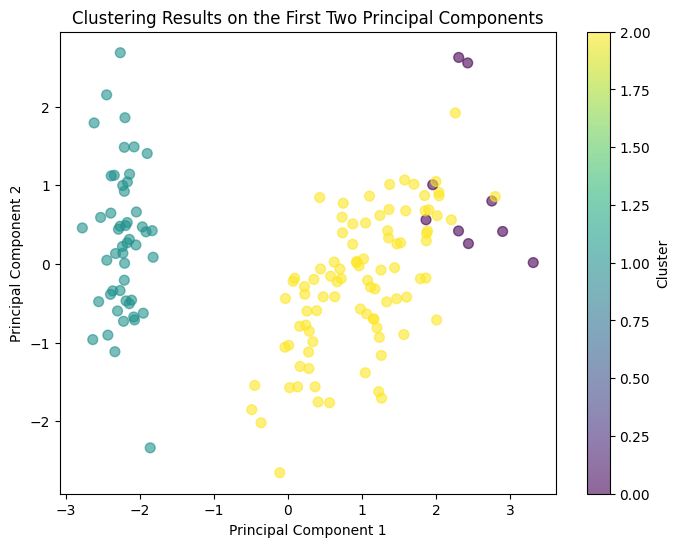

In [17]:
# Perform PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(iris_scaler)  # Apply PCA to the standardized data

# Assign each data point to the cluster with the highest responsibility
cluster_assignments = responsibilities.argmax(axis=1)

# Plot the results
plt.figure(figsize=(8, 6))

# Scatter plot with points colored by their cluster assignment
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_assignments, cmap='viridis', s=50, alpha=0.6)
plt.title("Clustering Results on the First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")

# Show the plot
plt.show()


### Question 3: California Housing Dataset

In [18]:
# Load the California Housing Dataset
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [19]:
# Select the variable "AveRooms" and add Gaussian noise
np.random.seed(42)  # Set seed for reproducibility
mu, sigma = 0, 0.5  # Mean and standard deviation for the noise
noise = np.random.normal(mu, sigma, df.shape[0])

# Create the corrupted variable
df['AveRooms_noisy'] = df['AveRooms'] + noise
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,AveRooms_noisy
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,7.232484
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,6.169005
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,8.611980
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,6.578867
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,6.164777


In [20]:
# Split the data into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Downsample the test data to 200 points for easier visualization
test = test.sample(n=200, random_state=42)

In [21]:
# Define and train the linear regression model
X_train = train[['AveRooms_noisy']]
y_train = train['AveRooms']
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [22]:
# Predict on the test set
X_test = test[['AveRooms_noisy']]
y_test = test['AveRooms']
y_pred = model.predict(X_test)

# Calculate bias and Mean Squared Error (MSE)
bias = np.mean(y_pred - y_test)
mse = mean_squared_error(y_test, y_pred)
print("Bias:", bias)
print("Mean Squared Error (MSE):", mse)


Bias: 0.07769959281149322
Mean Squared Error (MSE): 0.22696857849691912


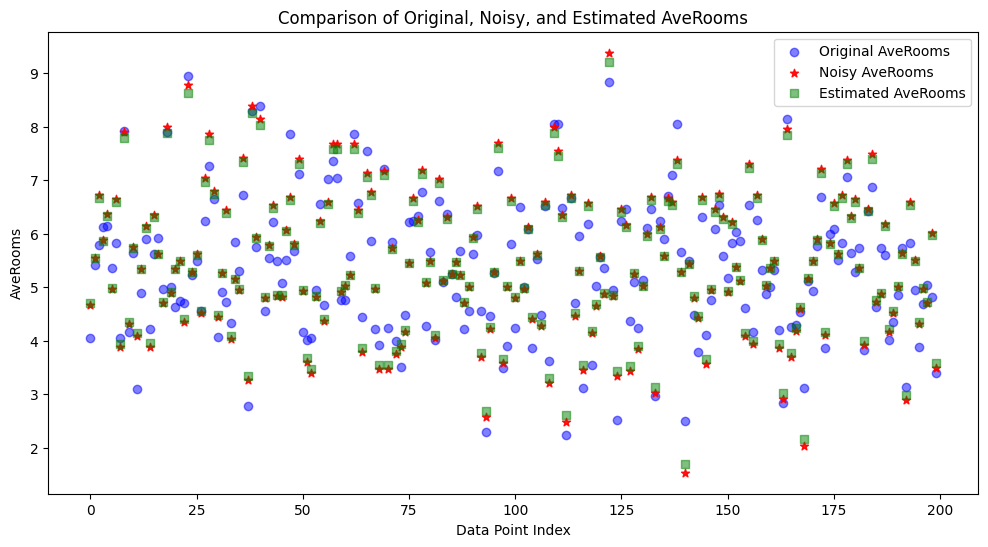

In [23]:
import matplotlib.pyplot as plt

# Plot original, noise-corrupted, and estimated values
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Original AveRooms', marker='o', alpha=0.5)
plt.scatter(range(len(y_test)), X_test['AveRooms_noisy'], color='red', label='Noisy AveRooms', marker='*', alpha=0.9)
plt.scatter(range(len(y_test)), y_pred, color='green', label='Estimated AveRooms', marker='s', alpha=0.5)
plt.legend()
plt.xlabel('Data Point Index')
plt.ylabel('AveRooms')
plt.title('Comparison of Original, Noisy, and Estimated AveRooms')
plt.show()


### Question 5: Simulation

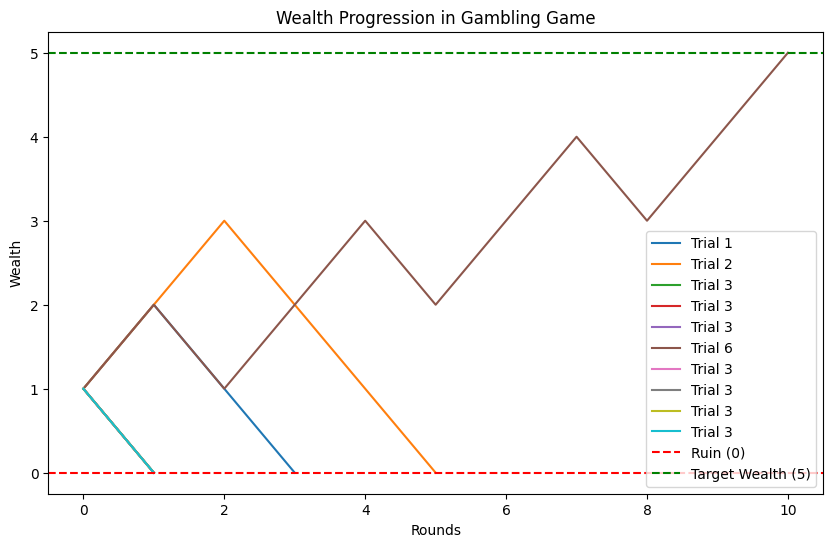

Number of Wins (Reached 5): 1
Number of Losses (Reached 0): 9
Average Number of Rounds per Trial: 2.5


In [24]:
import random
import matplotlib.pyplot as plt

# Function to simulate a gambling game
def simulate_game(initial_wealth, target_wealth, prob_win, num_trials):
    results = []
    
    for trial in range(num_trials):
        wealth = initial_wealth
        history = [wealth]
        
        # Simulate the game
        while wealth > 0 and wealth < target_wealth:
            if random.random() < prob_win:  # Win case
                wealth += 1
            else:  # Lose case
                wealth -= 1
            history.append(wealth)
        
        results.append(history)
    
    return results

# Parameters
initial_wealth = 1
target_wealth = 5
prob_win = 0.4
num_trials = 10

# Run simulation
results = simulate_game(initial_wealth, target_wealth, prob_win, num_trials)

# Visualize outcomes
plt.figure(figsize=(10, 6))
for trial in results:
    plt.plot(trial, label=f"Trial {results.index(trial)+1}")
plt.axhline(y=0, color='r', linestyle='--', label="Ruin (0)")
plt.axhline(y=target_wealth, color='g', linestyle='--', label="Target Wealth (5)")
plt.title("Wealth Progression in Gambling Game")
plt.xlabel("Rounds")
plt.ylabel("Wealth")
plt.legend()
plt.show()

# Analyze results
wins = sum(1 for trial in results if trial[-1] == target_wealth)
loses = num_trials - wins
avg_rounds = sum(len(trial) - 1 for trial in results) / num_trials

print(f"Number of Wins (Reached 5): {wins}")
print(f"Number of Losses (Reached 0): {loses}")
print(f"Average Number of Rounds per Trial: {avg_rounds}")
